In [1]:
!pip install pysastrawi

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
nltk.download('punkt')
import re
import json
import pickle

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory= StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
more_stopword = ['co', 'id', 'oleh','minggu','sabtu','senin','selasa','rabu','kamis','jumat']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hardi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
data = pd.read_csv("DETEKSI_HOAKS.csv")
fake = data.loc[data['label']==0]
true = data.loc[data['label']==1]

In [4]:
display("fake",fake)
display("true",true)

'fake'

,label,text
0,0,Perhelatan Puncak Balapan Formula E Sepi Peno...
1,0,"Faktanya, Komisaris PT Persib Bandung Bermarta..."
2,0,Nonton Gratis Pertandingan Sepakbola Antara P...
3,0,Albert Einstein: “Kejahatan ada ketika manusi...
4,0,Surat Pengangkatan Tenaga Honorer Menjadi PNS...
...,...,...
201,0,"Viral di media sosial, sebuah video menyebut l..."
202,0,Ivan Gunawan tak menyangka dirinya dikabarkan ...
203,0,Ivan Gunawan jadi korban berita meninggal. Fa...
204,0,Ivan Gunawan jadi korban berita meninggal. Fa...


'true'

,label,text
206,1,MotoGP Jerman 2022 berlangsung seru. Baru awal...
207,1,Sebuah mobil Damkar Pemkab Kediri alami kecela...
208,1,Prakiraan cuaca besok sudah diumumkan oleh BMK...
209,1,Diri sendiri bisa menjadi musuh terbesar dalam...
210,1,Buat detikers yang hendak terabas dengan mengg...
...,...,...
501,1,"Berbarengan dengan masuknya BA.4 dan BA.5, Ind..."
502,1,Seorang gadis di Pemalang ceritakan pengalaman...
503,1,Chen Kaishi yang dikenal dengan Gu Yazhen mema...
504,1,Aksi Christina Aguilera usai penampilannya di ...


In [5]:
data['text'] = data['text'].apply(lambda x: x.lower())
for index, row in data.iterrows():
    text = row['text'].split(' ')
    if text[0] == 'jakarta':
        del text[0]
    data.iloc[index, data.columns.get_loc('text')] = ' '.join(text)
data

,label,text
0,0,perhelatan puncak balapan formula e sepi peno...
1,0,"faktanya, komisaris pt persib bandung bermarta..."
2,0,nonton gratis pertandingan sepakbola antara p...
3,0,albert einstein: “kejahatan ada ketika manusi...
4,0,surat pengangkatan tenaga honorer menjadi pns...
...,...,...
501,1,"berbarengan dengan masuknya ba.4 dan ba.5, ind..."
502,1,seorang gadis di pemalang ceritakan pengalaman...
503,1,chen kaishi yang dikenal dengan gu yazhen mema...
504,1,aksi christina aguilera usai penampilannya di ...


In [6]:
#token for unormalize data
unnormalize = []
# fakeunnormalize =[]
# true
for index, row in data.iterrows():
    text = row['text']
    #text = stopword.remove(text)
    #text = text.encode("utf-8")
    #text_decode = str(text.decode("utf-8"))
    unnormalize += nltk.word_tokenize(text)
    
print("UNNORMALIZE TOKEN", len(unnormalize))
#remove duplicates
unnormalize_clean = list( dict.fromkeys(unnormalize))
print("UNNORMALIZE REMOVE DUPS", len(unnormalize_clean))

UNNORMALIZE TOKEN 13074
UNNORMALIZE REMOVE DUPS 3987


In [7]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# create stemmer
factory2 = StemmerFactory()
stemmer = factory2.create_stemmer()
def textEncode(text):
    text = text.encode("utf-8")
    text_decode = str(text.decode("utf-8"))
def casefolding(review):
    review = review.lower()
    return review
def tokenize(review):
    token =nltk.word_tokenize(review)
    return token
def stemming(review):
    review = stemmer.stem(review)
    return review
def filtering(review):
    review=re.sub(r'http\S+',' ',review)
    #
    review=re.sub('@[^\s]+',' ',review)
    #
    review=re.sub(r'#([^\s]+)','',review)
    #
    review=re.sub(r'[^\x00-\x7f]',r'',review)
    review=re.sub(r'(\\u[0-9A-Fa-f]+)',r'',review)
    review=re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ",review)
    review=re.sub(r'\\u\w\w\w\w','',review)
    #
    review=re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\d\*]", " ",review)
    return review 
def replaceThreeOrMore(review):
    pattern= re.compile(r"(.)\1{1,}",re.DOTALL)
    return pattern.sub(r"\1\1", review)
def removeDoubleSpaces(review):
    while '  ' in review:
        review= review.replace('  ',' ')
    return review
# def convertToSlangword(review):
#     kamus_slangword = open("slangword.txt",encoding="utf8").read()
#     kamus_slangword = json.loads(kamus_slangword)
#     review = review.split(' ')
#     content=[]
#     for kata in review:
#         if kata in kamus_slangword:
#             kata = kamus_slangword[kata]
#         content.append(kata)
#     return ' '.join(content)
def removeStopword(review):
#     stopwords = open('stopwords.txt','r').read().split()
#     content= []
#     filteredtext = [word for word in review.split() if word not in stopwords]
#     content.append(" ".join(filteredtext))
#     review = content
    review = stopword.remove(review)
    return review
def process_text(s):
    
    #checking punctuation
    nopunc = [char for char in s if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    #convert string to lowercase
    clean_string = [word for word in nopunc.split() if word.lower() not in stopwords.words('indonesian')]
    return clean_string
    

In [8]:
#test
#test
normalize = []
fake = []
true = []
for index, row in data.iterrows():
    test = row['text']
    test = casefolding(test)
     #print(test)
    test = filtering(test)
    test = stemming(test)
    #print(test)
    test = replaceThreeOrMore(test)
    #print(test)
    test = removeDoubleSpaces(test)
    #print(test)
#     test = convertToSlangword(test)
      #print(test)
    test = removeStopword(test)
      #print(test)
    test = tokenize(test)
    #print(test)
    normalize += test
    if row['label'] == 1 :
        true += test
    else:
        fake += test
print("NORMALIZE TOKEN", len(normalize))
normalize_clean = list(dict.fromkeys(normalize))
print("NORMALIZE REMOVE DUPS", len(normalize_clean))

NORMALIZE TOKEN 6548
NORMALIZE REMOVE DUPS 2438


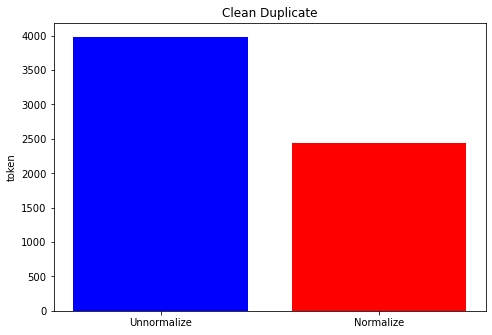

Dataset dinormalisasi sebesar 61.14873338349637%


In [9]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax= fig.add_axes([0,0,1,1])
langs = ['Unnormalize', 'Normalize']
students = [len(unnormalize_clean),len(normalize_clean)]
ax.bar(langs,students,color=['blue','red'])
ax.set_ylabel('token')
plt.title("Clean Duplicate")
plt.show()
normalpercent = (len(normalize_clean)/len(unnormalize_clean))*100
print("Dataset dinormalisasi sebesar "+ str(normalpercent)+"%")

In [10]:
!pip install wordcloud

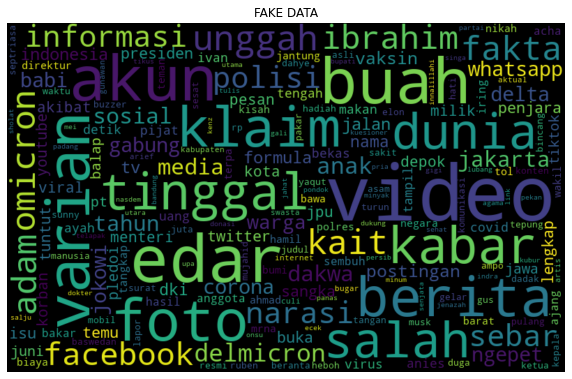

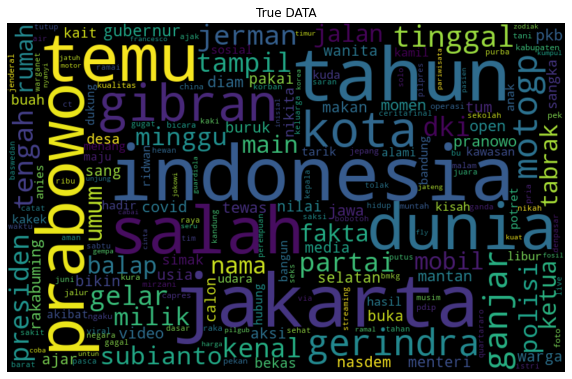

In [11]:
from wordcloud import WordCloud
all_words = ' '.join(normalize)
wordcloud = WordCloud(width=800, height=500,
                     max_font_size = 110,
                     collocations = False).generate(all_words)

all_words = ' '.join(fake)
wordcloud = WordCloud(width=800, height=500,
                     max_font_size = 110,
                     collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("FAKE DATA")
plt.show()

all_words = ' '.join(true)
wordcloud = WordCloud(width=800, height=500,
                     max_font_size = 110,
                     collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("True DATA")
plt.show()

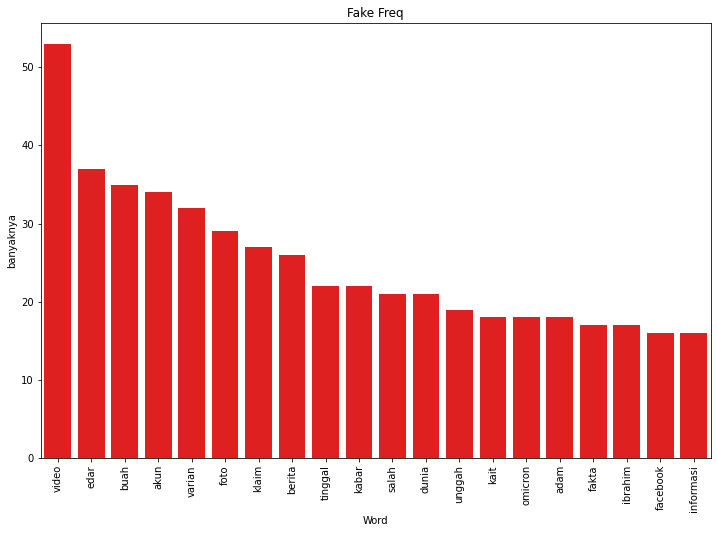

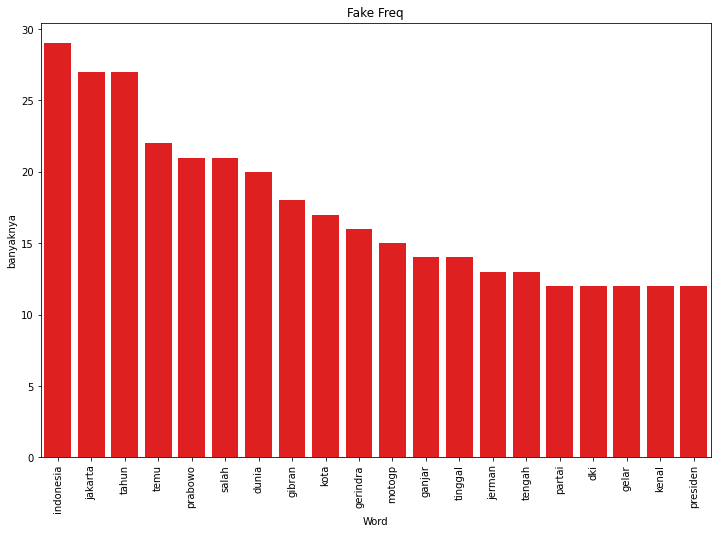

In [12]:
token_phrase = normalize
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"Word":list(frequency.keys()),
                            "Frequency":list(frequency.values())})
token_phrase = fake
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"Word":list(frequency.keys()),
                            "Frequency":list(frequency.values())})
df_frequency = df_frequency.nlargest(columns = "Frequency", n = 20)
plt.figure(figsize=(12,8))
ax= sns.barplot(data=df_frequency, x = "Word", y="Frequency", color= 'red')
ax.set(ylabel = "banyaknya")
plt.xticks(rotation = 'vertical')
plt.title('Fake Freq')
plt.show()

token_phrase = true
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"Word":list(frequency.keys()),
                            "Frequency":list(frequency.values())})
df_frequency = df_frequency.nlargest(columns = "Frequency", n = 20)
plt.figure(figsize=(12,8))
ax= sns.barplot(data=df_frequency, x = "Word", y="Frequency", color ='red')
ax.set(ylabel = "banyaknya")
plt.xticks(rotation = 'vertical')
plt.title('Fake Freq')
plt.show()

In [13]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory,StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# create stemmer
factory2 = StemmerFactory()
stemmer = factory2.create_stemmer()
stop_factory = StopWordRemoverFactory().get_stop_words()
more_stopword = ['co', 'id', 'oleh','minggu','sabtu','senin','selasa','rabu','kamis','jumat']

new_stopword = stop_factory+ more_stopword
dictionary = ArrayDictionary(new_stopword)
stopword = StopWordRemover(dictionary)
stopword


In [14]:
def process_text(review):
    #case folding
    review = review.lower()
    # menghapus link
    review=re.sub(r'http\S+',' ',review)
    #menghapus username
    review=re.sub('@[^\s]+',' ',review)
    #menghapus tanda baca
    review=re.sub(r'#([^\s]+)','',review)
    review=re.sub(r'[^\x00-\x7f]',r'',review)
    review=re.sub(r'(\\u[0-9A-Fa-f]+)',r'',review)
    review=re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ",review)
    review=re.sub(r'\\u\w\w\w\w','',review)
    #
    review=re.sub(r"[.,:;+!\-_<^/=?\"'\(\)\d\*]", " ",review)
    pattern= re.compile(r"(.)\1{1,}",re.DOTALL)
    review = pattern.sub(r"\1\1", review)
    
    
    while '  ' in review:
        review= review.replace('  ',' ')
    #menghapus stopword
    review = stopword.remove(review)
    #Stem kata
    review = stemmer.stem(review)
    #tokenisasi
    token =nltk.word_tokenize(review)
    
    return token
def rebrand(review):
    if review['label'] == 0:
        review['label'] = 'fake'
    else:
        review['label'] = 'true'
    return review

In [15]:
data_rebrand = data.apply(rebrand,axis = 1)
dataprocessed = data_rebrand.sample(frac=1)
dataprocessed

,label,text
1,fake,"faktanya, komisaris pt persib bandung bermarta..."
140,fake,"""jangan termakan isu-isu atau atau berita-ber..."
453,true,polisi masih memeriksa dua orang terkait acara...
271,true,empat hari berturut-turut kasus harian covid-1...
236,true,liu yu chen/ou xuan yi meraih gelar juara gand...
...,...,...
194,fake,menpan-rb tjahjo kumolo menjelaskan perihal in...
64,fake,"faktanya, tidak ditemukan informasi resmi dan ..."
158,fake,terdakwa adam ibrahim divonis 4 tahun penjara ...
471,true,bengkel kaki palsu than must soegeng mirtha pr...


In [16]:
import string
def process_text2(s):
    
    #checking punctuation
    nopunc = [char for char in s if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    #convert string to lowercase
    clean_string = [word for word in nopunc.split() if word.lower() not in new_stopword]
    return clean_string

In [17]:
dataprocessed['token'] = dataprocessed['text'].apply(process_text)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
import string

In [19]:
dataprocessed.sample(40)
bow_transformer = CountVectorizer(analyzer=process_text2).fit(dataprocessed['token'])

print(len(bow_transformer.vocabulary_))

480


In [21]:
dataprocessed['token']

1      [fakta, komisaris, pt, persib, bandung, martab...
140    [makan, isu, isu, berita, berita, sesat, kepal...
453    [polisi, periksa, kait, acara, muat, sensual, ...
271    [hari, covid, indonesia, tembus, angka, ribu, ...
236    [liu, yu, chen, ou, xuan, yi, raih, gelar, jua...
                             ...                        
194    [menpan, rb, tjahjo, kumolo, perihal, insiden,...
64     [fakta, temu, informasi, resmi, valid, klaim, ...
158    [dakwa, adam, ibrahim, vonis, tahun, penjara, ...
471    [bengkel, kaki, palsu, than, must, soegeng, mi...
228    [mari, angkat, topi, pep, guardiola, karier, l...
Name: token, Length: 506, dtype: object

In [22]:
news_bow = bow_transformer.transform(dataprocessed['token'])

In [23]:
print('shape :',news_bow.shape)
print('amnt of non zero occ :',news_bow.nnz)

shape : (506, 480)
amnt of non zero occ : 506


In [24]:
spars = (100.0 *news_bow.nnz/(news_bow.shape[0]*news_bow.shape[1]))
print('spars: {}'.format(round(spars)))

spars: 0


In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(news_bow)
news_tfidf = tfidf_transformer.transform(news_bow)
print(news_tfidf.shape)

(506, 480)


In [26]:
#train nbmodel
from sklearn.naive_bayes import MultinomialNB
fakenews_detect_model = MultinomialNB().fit(news_tfidf,dataprocessed['label'])

In [27]:
prediction = fakenews_detect_model.predict(news_tfidf)
print(prediction)

['fake' 'fake' 'true' 'true' 'true' 'true' 'fake' 'true' 'true' 'true'
 'fake' 'true' 'true' 'fake' 'fake' 'fake' 'fake' 'true' 'fake' 'fake'
 'fake' 'fake' 'fake' 'true' 'true' 'true' 'fake' 'true' 'fake' 'true'
 'fake' 'fake' 'true' 'fake' 'true' 'true' 'fake' 'fake' 'true' 'true'
 'fake' 'true' 'fake' 'true' 'fake' 'fake' 'true' 'true' 'fake' 'fake'
 'true' 'true' 'true' 'true' 'true' 'fake' 'true' 'true' 'fake' 'fake'
 'fake' 'true' 'true' 'true' 'true' 'fake' 'true' 'fake' 'true' 'true'
 'true' 'fake' 'fake' 'fake' 'true' 'fake' 'true' 'fake' 'fake' 'true'
 'true' 'fake' 'fake' 'true' 'fake' 'true' 'true' 'fake' 'true' 'true'
 'fake' 'true' 'fake' 'true' 'fake' 'true' 'fake' 'fake' 'true' 'fake'
 'true' 'true' 'true' 'fake' 'true' 'true' 'fake' 'fake' 'fake' 'true'
 'fake' 'fake' 'true' 'true' 'true' 'true' 'fake' 'true' 'true' 'fake'
 'true' 'true' 'true' 'fake' 'true' 'true' 'fake' 'true' 'fake' 'fake'
 'true' 'true' 'true' 'fake' 'true' 'fake' 'fake' 'true' 'true' 'true'
 'fake

In [28]:
from sklearn.metrics import classification_report
print (classification_report(dataprocessed['label'],prediction))

              precision    recall  f1-score   support

        fake       1.00      1.00      1.00       206
        true       1.00      1.00      1.00       300

    accuracy                           1.00       506
   macro avg       1.00      1.00      1.00       506
weighted avg       1.00      1.00      1.00       506



In [106]:
from sklearn.model_selection import train_test_split 
news_train, news_test,text_train,text_test = train_test_split(dataprocessed['text'],
                                                              dataprocessed['label'],test_size = 0.27,
                                                              random_state=0)

print(len(news_train), len(news_test), len(news_train)+len(news_test))

369 137 506


In [107]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process_text)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB(alpha = 1.0)),
])
pipeline.fit(news_train,text_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x00000221A0515790>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [108]:
news_test

479    #foto lukisan kaca nagasepaha karya seniman ba...
232    rumah nikita mirzani dikepung pihak kepolisian...
206    motogp jerman 2022 berlangsung seru. baru awal...
456    ramalan zodiak aquarius ada saja pengeluaran d...
52      akun whatsapp bupati enrekang melakukan pengg...
                             ...                        
460    eddie nketiah adalah masa depan arsenal. oleh ...
332    peristiwa penemuan mayat hingga kebakaran dala...
185    polisi telah menetapkan direktur bstv bondowos...
89      “perahu wisatawan di hantam ombak laut pangan...
310    manchester city belum puas walau sudah datangk...
Name: text, Length: 137, dtype: object

In [115]:
test =news_test.iloc[0]
test =' Panggilan Interview Kerja oleh PT Petrogas Jatim Utama Melalui WhatsApp  Beredar informasi melalui WhatsApp terkait dengan panggilan interview kerja di PT Petrogas Jatim Utama.'
prediksi = pipeline.predict([test]) 
print(prediksi)

['fake']


In [110]:
predictions = pipeline.predict(news_test)
#print(predictions)
print(classification_report(predictions,text_test))

              precision    recall  f1-score   support

        fake       0.81      0.86      0.84        51
        true       0.92      0.88      0.90        86

    accuracy                           0.88       137
   macro avg       0.87      0.87      0.87       137
weighted avg       0.88      0.88      0.88       137



In [111]:
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score

# acc_score = accuracy_score(text_test, prediksi)
conf_mat = confusion_matrix(
        text_test, predictions)
print (conf_mat)

[[44 10]
 [ 7 76]]


In [35]:
conf_mat2 = confusion_matrix(
        dataprocessed['label'], prediction)
print (conf_mat2)

[[206   0]
 [  0 300]]


In [36]:
prediksi.shape

(1,)